This notebook describes the dataset and gets useful insights from it:
- Number of decisions by chamber/court/canton/language
- Number of tokens on average by chamber/court/canton/language
- Date range by chamber/court/canton/language

In [195]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
import random
from somajo import SoMaJo # German tokenizer
tokenizer = SoMaJo("de_CMC")

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [196]:
data_dir = Path('../../data')
csv_dir = data_dir / 'csv'
clean_csv_dir = csv_dir / 'clean'

In [197]:
court_dir = clean_csv_dir / '_de.csv'
court_dir

PosixPath('../../data/csv/clean/_de.csv')

In [198]:
# select only small random subset for testing
# keep the header, then take only 1% of lines
# if random from [0,1] interval is greater than 0.01 the row will be skipped
p = 0.001
df = pd.read_csv(
             court_dir,
             header=0, 
             skiprows=lambda i: i>0 and random.random() > p
    )

In [199]:
# clean
df['text'] = np.where(df['html_clean'].notna(), df['html_clean'], df['pdf_clean']) # Combine columns into one easy to use text column
df = df.drop(['html_clean', 'pdf_clean'], axis='columns') # drop old columns
print('Combined columns into one easy to use text column')
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df.head()

Combined columns into one easy to use text column


,court_class,court_id,canton,file_name,file_number,file_number_additional,url,date,language,text
0,ZH_Obergericht,ZH_OG_001,ZH,ZH_OG_001_LA130005_2013-04-12,LA130005,NaN,https://www.gerichte-zh.ch/fileadmin/user_uplo...,2013-04-12,de,Urteil Berufung Obergericht des Kantons Züric...
1,ZH_Obergericht,ZH_OG_001,ZH,ZH_OG_001_RT140179_17-02-2015,RT140179,NaN,https://www.gerichte-zh.ch/fileadmin/user_uplo...,17.02.2015,de,Urteil Gutheissung/Abweisung Beschwerde Oberge...
2,ZH_Obergericht,ZH_OG_999,ZH,ZH_OG_999_HG170146_07-11-2017,HG170146,NaN,https://www.gerichte-zh.ch/fileadmin/user_uplo...,07.11.2017,de,U47710 Handelsgericht des Kantons Zürich Gesc...
3,ZH_Obergericht,ZH_OG_005,ZH,ZH_OG_005_AC050089_23-01-2006,AC050089,NaN,https://www.gerichte-zh.ch/fileadmin/user_uplo...,23.01.2006,de,Kassationsgericht des Kantons Zürich Kass.-Nr...
4,ZH_Obergericht,ZH_OG_001,ZH,ZH_OG_001_RT120039_2012-06-11,RT120039,NaN,https://www.gerichte-zh.ch/fileadmin/user_uplo...,2012-06-11,de,"Art Art. 80 Abs. 1 SchKG; Art. 239, 321 Abs. 1..."


In [204]:
def tokenize(text):
    """tokenize with somajo. Remove all non-word characters"""
    sentences = tokenizer.tokenize_text([text])
    # remove non-words (emoticons, punctuation, etc.)
    return [token.text for sentence in sentences for token in sentence if token.token_class == 'regular']

df['tokens'] = df['text'].parallel_apply(lambda x: tokenize(x))
df['num_tokens'] = df['tokens'].str.len() # count entries in the list
df.head()

,court_class,court_id,canton,file_name,file_number,file_number_additional,url,date,language,text,year,tokens,num_tokens
0,ZH_Obergericht,ZH_OG_001,ZH,ZH_OG_001_LA130005_2013-04-12,LA130005,NaN,https://www.gerichte-zh.ch/fileadmin/user_uplo...,2013-04-12,de,Urteil Berufung Obergericht des Kantons Züric...,2013,"[Urteil, Berufung, Obergericht, des, Kantons, ...",3957
1,ZH_Obergericht,ZH_OG_001,ZH,ZH_OG_001_RT140179_17-02-2015,RT140179,NaN,https://www.gerichte-zh.ch/fileadmin/user_uplo...,2015-02-17,de,Urteil Gutheissung/Abweisung Beschwerde Oberge...,2015,"[Urteil, Gutheissung, Abweisung, Beschwerde, O...",652
2,ZH_Obergericht,ZH_OG_999,ZH,ZH_OG_999_HG170146_07-11-2017,HG170146,NaN,https://www.gerichte-zh.ch/fileadmin/user_uplo...,2017-07-11,de,U47710 Handelsgericht des Kantons Zürich Gesc...,2017,"[Handelsgericht, des, Kantons, Zürich, Geschäf...",2384
3,ZH_Obergericht,ZH_OG_005,ZH,ZH_OG_005_AC050089_23-01-2006,AC050089,NaN,https://www.gerichte-zh.ch/fileadmin/user_uplo...,2006-01-23,de,Kassationsgericht des Kantons Zürich Kass.-Nr...,2006,"[Kassationsgericht, des, Kantons, Zürich, Mitw...",5317
4,ZH_Obergericht,ZH_OG_001,ZH,ZH_OG_001_RT120039_2012-06-11,RT120039,NaN,https://www.gerichte-zh.ch/fileadmin/user_uplo...,2012-06-11,de,"Art Art. 80 Abs. 1 SchKG; Art. 239, 321 Abs. 1...",2012,"[Art, Art, SchKG, Art, ZPO, Art, BGG, In, der,...",2255


In [205]:
# Set seaborn variables
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(20,6)})

In [215]:
def plot_dates(df, title):
    grouped_df = df.groupby('year').agg(num_decisions=('court_id', 'count')).reset_index()
    ax = sns.barplot(data=grouped_df, x='year', y='num_decisions')
    ax.set(title=title)
    return ax

<AxesSubplot:title={'center':'Sample of 324 Swiss German Court Decisions'}, xlabel='year', ylabel='num_decisions'>

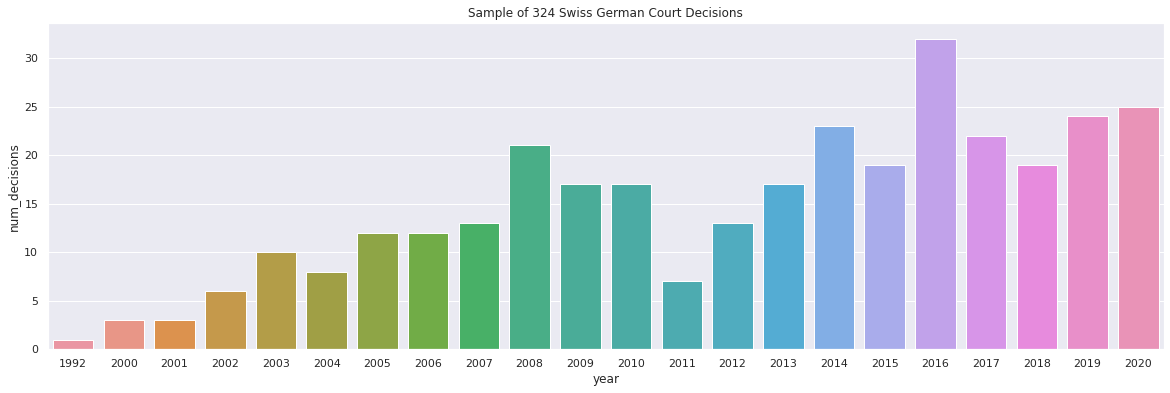

In [216]:
plot_dates(df, title)

In [206]:
def plot_tokens(df, column, title, estimator=np.median):
    ax = sns.barplot(x=column, y="num_tokens", data=df, estimator=estimator)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
    ax.set(title=title)
    return ax

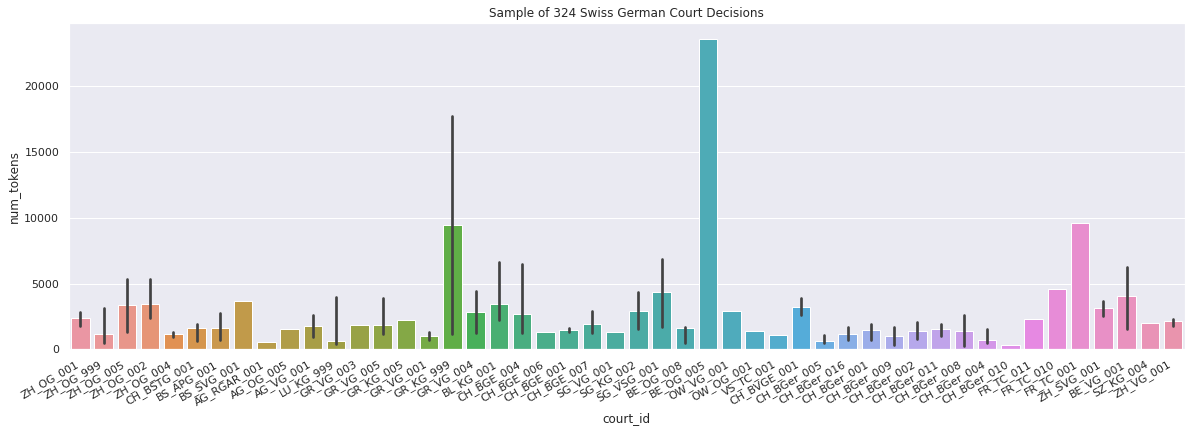

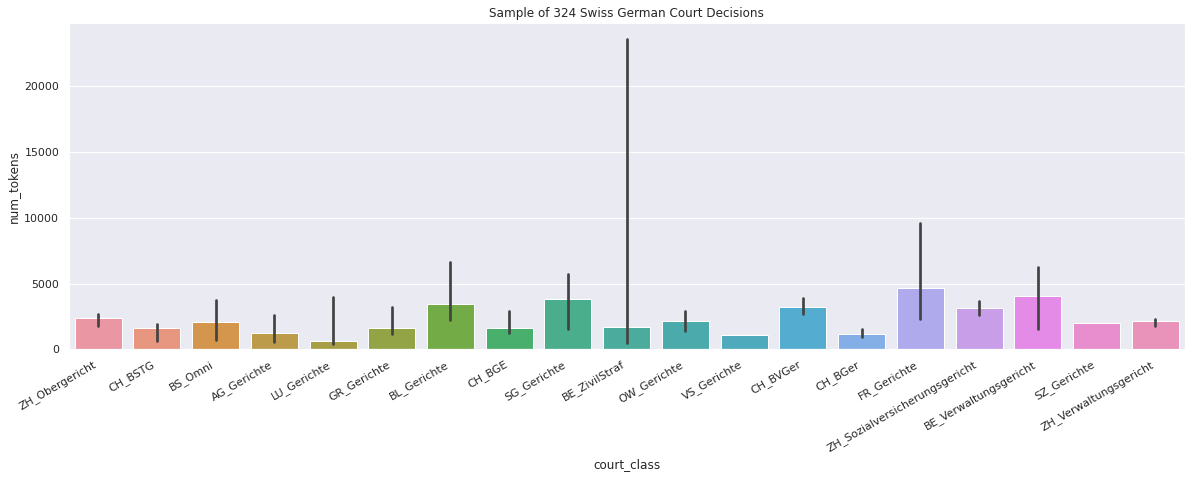

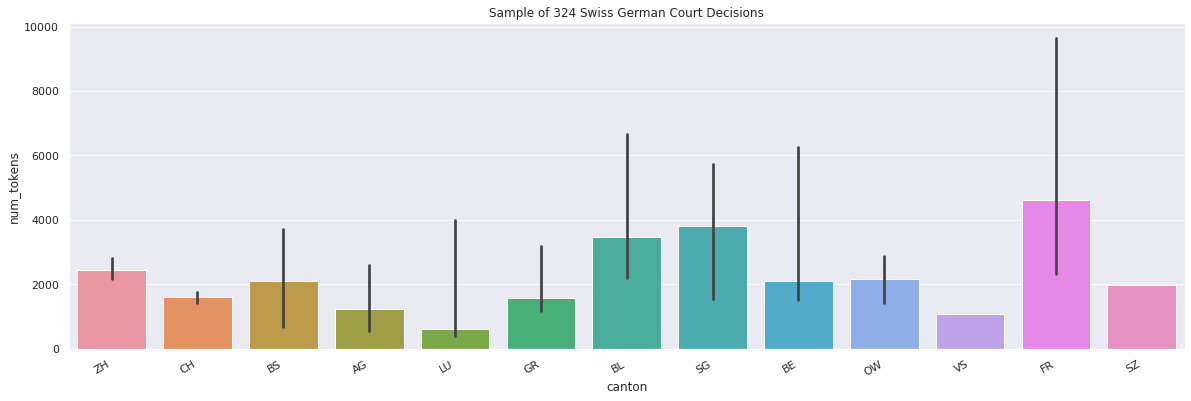

In [207]:
title = f'Sample of {len(df)} Swiss German Court Decisions'
court_id = plot_tokens(df, "court_id", title)
plt.show()
court_class = plot_tokens(df, "court_class", title)
plt.show()
canton = plot_tokens(df, "canton", title)
plt.show()

In [208]:
def plot_decisions_count(df, column, title):
    ax = sns.countplot(x=column, data=df)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
    ax.set(ylabel='num_decisions', title=title)
    return ax

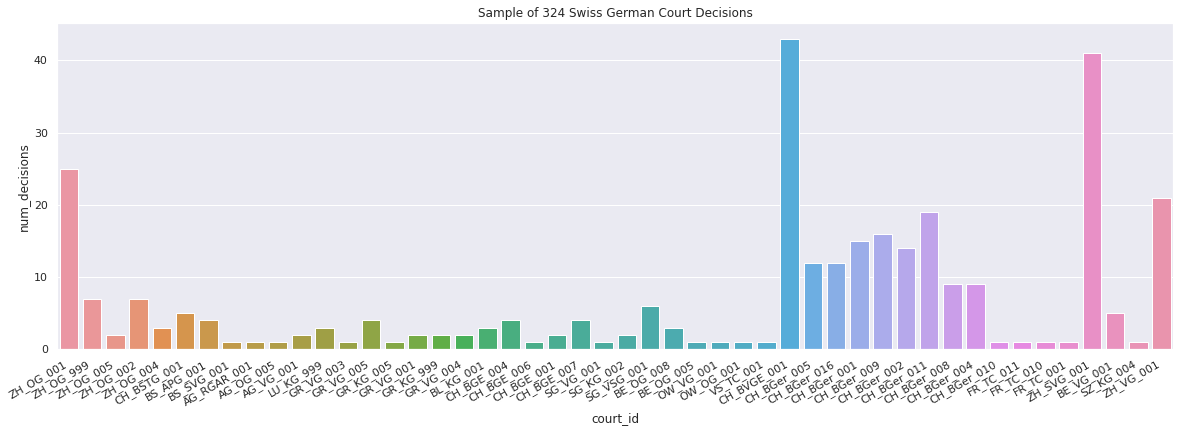

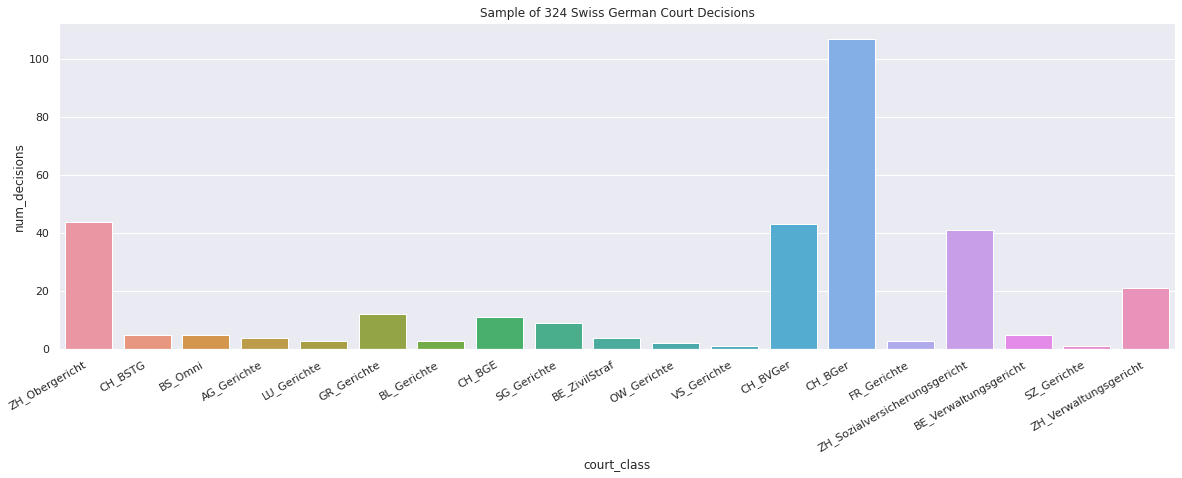

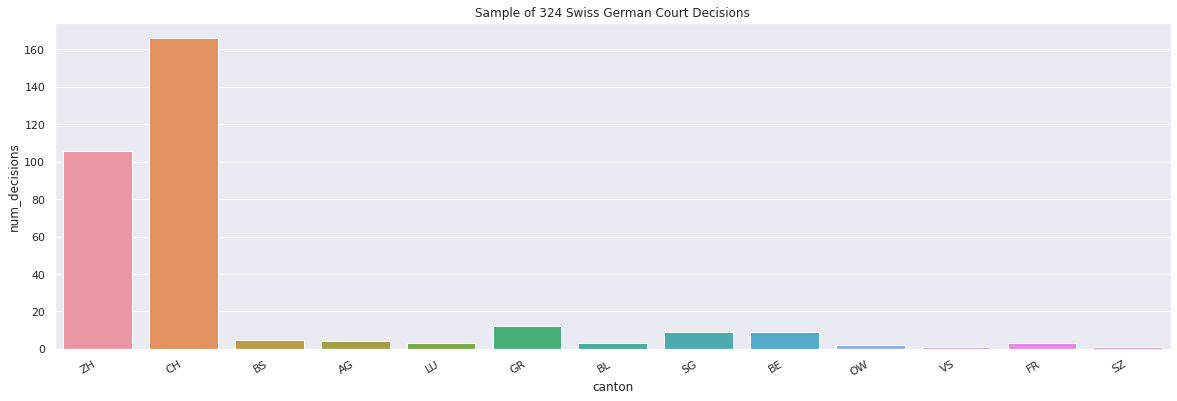

In [209]:
court_id = plot_decisions_count(df, "court_id", title)
plt.show()
court_class = plot_decisions_count(df, "court_class", title)
plt.show()
canton = plot_decisions_count(df, "canton", title)
plt.show()